# Medical Cost
Using the https://www.kaggle.com/mirichoi0218/insurance dataset to estimate the medical chargess

In [1]:
import pandas as pd 
df=pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
age,0,0.0
sex,0,0.0
bmi,0,0.0
children,0,0.0
smoker,0,0.0
region,0,0.0
charges,0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


There are no missing values and all of the data types are in order

## Data Exploration

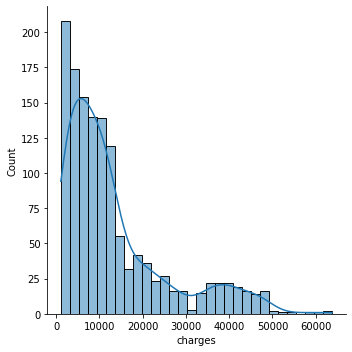

In [6]:
import seaborn as sns
sns.displot(df['charges'],kde=True)

This is right skewed so we will normalize it

In [7]:
import numpy as np
df["charges"] = np.log1p(df["charges"])

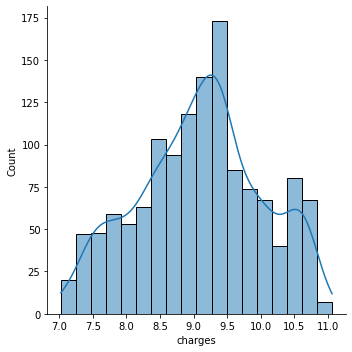

In [8]:
sns.displot(df['charges'],kde=True)

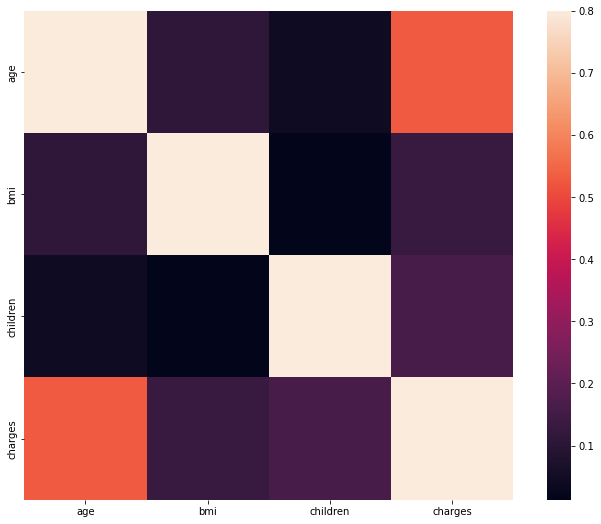

In [9]:
import matplotlib.pyplot as plt

corr = df.corr()
fig, ax = plt.subplots(figsize=(12,9))     
sns.heatmap(corr, vmax=.8, square=True);

C:\Users\Andrew\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


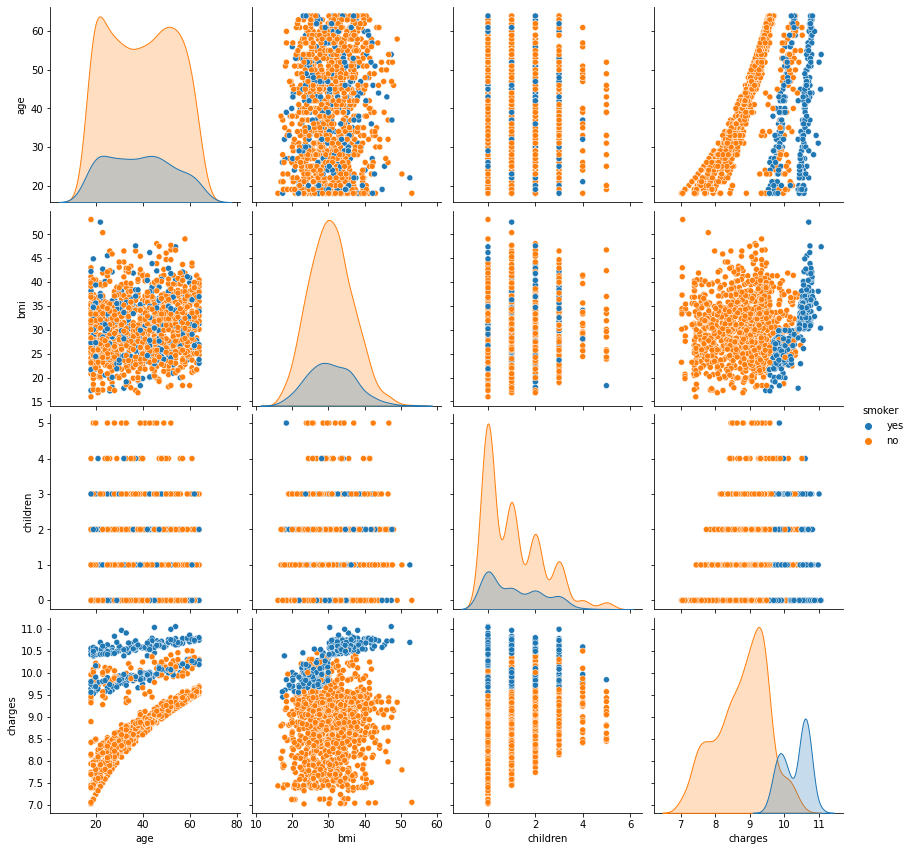

In [12]:
sns.pairplot(df,hue='smoker', size=3)

This shows that there is a strong correlation between smoking and charges as well as the age and charges. Neither is unexpected.

## Machine learning 

In [21]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df,test_size=0.2)
train_y=train_set["charges"]
train_x=train_set.drop(["charges"], axis=1)
test_y=test_set["charges"]
test_x=test_set.drop(["charges"], axis=1)

In [14]:
train_set_num=train_x.select_dtypes(include=[np.number])
train_set_ob=train_x.select_dtypes(include=[object])
num_column=list(train_set_num.columns)
ob_column=list(train_set_ob.columns)

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_column),
        ("cat", OneHotEncoder(), ob_column),
    ])

train_prepared = full_pipeline.fit_transform(train_x)
test_prepared = full_pipeline.fit_transform(test_x)

In [38]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def eval(model,test_x,test_y):
    ymul=model.predict(test_x)
    print("Model score: %.2f" % model.score(test_x,test_y))
    print("Mean absolute error: %.2f" % np.mean(np.absolute(ymul - test_y)))
    print("Residual sum of squares (MSE): %.2f" % np.mean((ymul - test_y) ** 2))
    print("R2-score: %.2f" % r2_score(test_y , ymul) )
    score=np.sqrt(-cross_val_score(model, train_prepared, train_y, scoring="neg_mean_squared_error", cv = 10))
    print("RMSE score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [39]:
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

In [40]:
lin_reg=LinearRegression()
lin_reg.fit(train_prepared,train_y)
eval(lin_reg,test_prepared,test_y)

Model score: 0.82
Mean absolute error: 0.24
Residual sum of squares (MSE): 0.15
R2-score: 0.82
RMSE score: 0.4560 (0.0671)



In [41]:
ridge_reg=Ridge(alpha=1,solver="cholesky")
ridge_reg.fit(train_prepared,train_y)
eval(ridge_reg,test_prepared,test_y)

Model score: 0.82
Mean absolute error: 0.24
Residual sum of squares (MSE): 0.15
R2-score: 0.82
RMSE score: 0.4560 (0.0671)



In [42]:
lasso_reg=Lasso(alpha =0.1, random_state=1)
lasso_reg.fit(train_prepared,train_y)
eval(lasso_reg,test_prepared,test_y)

Model score: 0.68
Mean absolute error: 0.35
Residual sum of squares (MSE): 0.27
R2-score: 0.68
RMSE score: 0.5459 (0.0493)



In [43]:
elastic_net = ElasticNet(alpha=0.1,l1_ratio=0.5)
elastic_net.fit(train_prepared,train_y)
eval(elastic_net,test_prepared,test_y)

Model score: 0.73
Mean absolute error: 0.31
Residual sum of squares (MSE): 0.22
R2-score: 0.73
RMSE score: 0.5078 (0.0543)



In [44]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.05, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.78, n_estimators=2200,
                             reg_alpha=0.46, reg_lambda=0.85,
                             subsample=0.52, verbosity=0,
                             random_state =7, nthread = -1)
model_xgb.fit(train_prepared,train_y)
eval(model_xgb,test_prepared,test_y)

Model score: 0.87
Mean absolute error: 0.20
Residual sum of squares (MSE): 0.11
R2-score: 0.87
RMSE score: 0.4198 (0.0794)



This shows that the model works fairly well, however there can be large differences between the expected and actual. I will now try and find the best values for the xgboost regressor

In [51]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint

param_grid= {
        'colsample_bytree': randint(low=0.1, high=1), # Can only be between 0 and 1
        'gamma': randint(low=0.01, high=1),
        'learning_rate': randint(low=0.05, high=1),
        'max_depth': randint(low=1, high=5),
        'min_child_weight': randint(low=0.1, high=10),
        'n_estimators': randint(low=2000, high=3000),
        'reg_alpha': randint(low=0.1, high=1),
        'subsample': randint(low=0.1, high=1), # Can only be between 0 and 1
        'reg_lambda': randint(low=0.1, high=1),
    }

rnd_search = RandomizedSearchCV(model_xgb, param_distributions=param_grid,
                                n_iter=100, cv=3, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(train_prepared, train_y)
rnd_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0, max_delta_step=0, max_depth=3, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=2860,
             n_jobs=12, nthread=-1, num_parallel_tree=1, random_state=7,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=0,
             tree_method='exact', validate_parameters=1, verbosity=0)

In [50]:
model_xgb
model_xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0, gamma=6, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=3, max_delta_step=0, max_depth=8, min_child_weight=4, monotone_constraints='()', n_estimators=2638,
             n_jobs=12, nthread=-1, num_parallel_tree=1, random_state=7,
             reg_alpha=9, reg_lambda=2, scale_pos_weight=1, subsample=0,
             tree_method='exact', validate_parameters=1, verbosity=0)
model_xgb.fit(train_prepared,train_y)
eval(model_xgb,test_prepared,test_y)

Model score: -88.97
Mean absolute error: 8.64
Residual sum of squares (MSE): 75.42
R2-score: -88.97
RMSE score: 8.6382 (0.0782)



The problem with trying to optimise the hyperparameters with xgboost is the number of them, there are just to many cobinations. I wil try with ridge as well 

In [52]:
param_grid= {
        'alpha': randint(low=0.0, high=300.0),
    }

rnd_search = RandomizedSearchCV(ridge_reg, param_distributions=param_grid,
                                n_iter=300, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(train_prepared, train_y)
rnd_search.best_estimator_

Ridge(alpha=1, solver='cholesky')

In [53]:
ridge_reg=Ridge(alpha=1,solver="cholesky")
ridge_reg.fit(train_prepared,train_y)
eval(ridge_reg,test_prepared,test_y)

Model score: 0.82
Mean absolute error: 0.24
Residual sum of squares (MSE): 0.15
R2-score: 0.82
RMSE score: 0.4560 (0.0671)

